In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory='my_chroma_db',
    collection_name='sample'
)

In [2]:
retriever = vector_store.as_retriever()

In [3]:

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
exam_vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory='examination_cell_03',
    collection_name='sample'
)

In [4]:
exam_retriever = exam_vector_store.as_retriever(search_type="mmr",
    search_kwargs={
        "k": 4,
        "fetch_k": 20,
        "lambda_mult": 0.5
    })

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
notice_board_store = Chroma(
    embedding_function=embeddings,
    persist_directory='notice_board_3',
    collection_name='sample'
)

In [6]:
notice_retriever = notice_board_store.as_retriever(search_type="mmr",
    search_kwargs={
        "k": 4,
        "fetch_k": 20,
        "lambda_mult": 0.5
    })

In [7]:
from langchain.tools import tool

@tool
def retrieve_blog_posts(query: str) -> str:
    """
    Search and return official university information, including:
    - University overview, rankings, and accreditations
    - Admissions process and entrance exams
    - Eligibility criteria for all courses
    - Scholarships and education loans
    - Office roles, responsibilities, and contact details
    - Fees, payments, and refund policies
    - Campus policies, facilities, and student life
    - International student admissions and requirements
    - Placements, recruiters, and career outcomes
    """
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve_blog_posts

In [8]:
@tool
def retrieve_examination_cell_doc(query: str) -> str:
    """
    Search and return official university exam notifications,
    schedules, admit card releases, result notices, and 
    examination circulars .
    """
    docs = exam_retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

examination_cell_retriever = retrieve_examination_cell_doc

In [9]:
@tool
def retrieve_notice_board_doc(query: str) -> str:
    """
    Search and return official university notices and announcements
    from the CGU Odisha Notice Board ,
    including:
    - Admit card distribution updates
    - Time table for any course/Branch
    - Notifications about academic activities
    - Convocation and award announcements
    - Other official circulars and events
    """
    docs = notice_retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

notice_board_doc = retrieve_notice_board_doc

In [10]:
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
load_dotenv()
websearch_tool = TavilySearch(
    max_results=5,
    include_raw_content=True,
    search_depth="advanced",
    include_domains=[
        "https://x.com/CguOdisha"
    ],
)

d:\abhi_project\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
d:\abhi_project\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [11]:
from langgraph.graph import MessagesState
from typing import Annotated
from langchain.chat_models import init_chat_model

class AgentState(MessagesState):
    rewrite_count: Annotated[int, "Number of question rewrites"] = 0
    answer_retry_count: Annotated[int, "Number of answer regenerations"] = 0

response_model = init_chat_model("gpt-4o-mini", temperature=0)


def generate_query_or_respond(state: AgentState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever_tool,examination_cell_retriever,notice_board_doc
    websearch_tool or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool,examination_cell_retriever,notice_board_doc,websearch_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [12]:
from langchain.messages import HumanMessage , ToolMessage
def get_latest_user_question(messages):
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content
    return ""


In [13]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("gpt-4o", temperature=0)


def grade_documents(
    state: AgentState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = get_latest_user_question(state["messages"])

    context = state["messages"][-1].content

    rewrite_count = state.get("rewrite_count", 0)

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    
    score = response.binary_score
    print(f"📊 Document relevance grade: {score} (Rewrite attempt: {rewrite_count})")
    
    # Check if we've hit the rewrite limit
    if rewrite_count >= 2:
        print("⚠️ Max rewrites reached. Proceeding to generate answer with available context.")
        return "generate_answer"
    
    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [14]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: AgentState):
    """Rewrite the original user question."""
    messages = state["messages"]
    # Safety: do not rewrite if tool already returned content
    if any(isinstance(m, ToolMessage) and m.content.strip() for m in messages):
        return {"rewrite_count": state.get("rewrite_count", 0)}
    question = get_latest_user_question(messages)

    current_count = state.get("rewrite_count", 0)
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {
        "messages": [HumanMessage(content=response.content)],
        "rewrite_count": current_count + 1
    }

In [15]:
from langchain_core.messages import SystemMessage, HumanMessage,ToolMessage
def generate_answer(state: AgentState):
    """Generate an answer."""
    question = get_latest_user_question(state["messages"])
    context = state["messages"][-1].content
    context_list = [m.content for m in state["messages"] if isinstance(m, ToolMessage)]
    context = "\n\n".join(context_list)
    retry_count = state.get("answer_retry_count", 0)

    GENERATE_PROMPT = [
        SystemMessage(content="You are an assistant for question-answering tasks for C.V Raman global university,Bhubaneswar,Odisha,India (CGU)."),
        HumanMessage(content=f"""
Use the following pieces of retrieved context to answer the question. 
If tools answer is not related to the user question, just say that you don't know. 
Question: {question}
Context: {context}
""")
    ]
    response = response_model.invoke(GENERATE_PROMPT)
    return {
        "messages": [response],
        "answer_retry_count": retry_count + 1
    }

In [16]:
from langgraph.graph import END
HALLUCINATION_PROMPT = (
    "You are a hallucination detector. Review the following answer in relation to the user's question.\n"
    "Question: {question}\n"
    "Answer: {answer}\n\n"
    "If the answer is factual, relevant, and grounded in the question context, respond 'no'. "
    "If it seems incorrect, fabricated, or off-topic, respond 'yes'."
)

class HallucinationCheck(BaseModel):
    hallucination: Literal["yes", "no"] = Field(..., description="Final evaluation result.")

def check_hallucination(state: AgentState) -> dict:
    """Check if the generated answer is hallucinated."""
    question = get_latest_user_question(state["messages"])
    answer = state["messages"][-1].content
    
    retry_count = state.get("answer_retry_count", 0)

    prompt = HALLUCINATION_PROMPT.format(question=question, answer=answer)
    response = (
        grader_model
        .with_structured_output(HallucinationCheck)
        .invoke([{"role": "user", "content": prompt}])
    )
    
    hallucination_score = response.hallucination
    print(f"📊 Hallucination score: {hallucination_score} (Retry attempt: {retry_count})")
    
    # Check if we've hit the retry limit
    if retry_count >= 2:
        print("⚠️ Max answer retries reached. Returning current answer.")
        return END
    
    if hallucination_score == "yes":
        return "generate_answer"
    else:
        return END

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool,examination_cell_retriever,notice_board_doc,websearch_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_conditional_edges(
    "generate_answer",
    # Assess agent decision
    check_hallucination,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

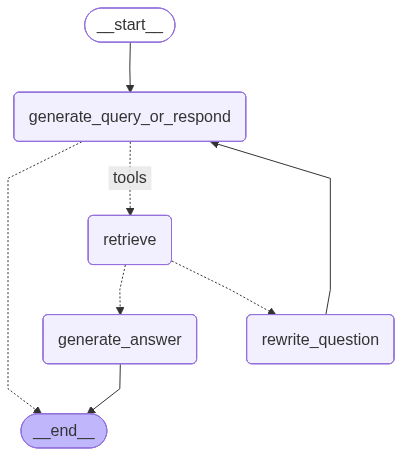

In [18]:
graph

In [19]:
from dotenv import load_dotenv
load_dotenv()

True

In [20]:
from langchain.messages import ToolMessage, AIMessage
from langsmith import traceable

@traceable(name="CGU_LangGraph_RAG")
def rag_bot(question: str) -> dict:

    final_state = graph.invoke({
        "messages": [{"role": "user", "content": question}]
    })

    final_answer = None
    final_documents = None

    for msg in final_state["messages"]:
        if isinstance(msg, ToolMessage):
            # overwrite → last accepted retriever output wins
            final_documents = msg.content

        if isinstance(msg, AIMessage):
            final_answer = msg.content

    return {
        "answer": final_answer,
        "documents": final_documents
    }


In [23]:
from langsmith import Client

client = Client()
examples = [
    {
        "inputs": {"question": "How can I pay my fees online at C. V. Raman Global University?"},
        "outputs": {"answer": "Fees can be paid online by visiting the Eduqfix payment portal, selecting C. V. Raman Global University as the branch, entering the university roll number or registration number, choosing the fee type, entering the amount, and clicking Continue to complete the payment."},
    },
    {
        "inputs": {"question": "What is the tuition fee per semester for BTech Computer Science Engineering (AI & Machine Learning)?"},
        "outputs": {"answer": "The tuition fee per semester for BTech Computer Science Engineering (AI & Machine Learning) is ₹1,50,000 and the duration of the program is four years."},
    },
    {
        "inputs": {"question": "What is the fee per semester for BTech Computer Science Engineering (Data Science)?"},
        "outputs": {"answer": "The tuition fee per semester for BTech Computer Science Engineering (Data Science) is ₹1,45,000 for a duration of four years."},
    },
    {
        "inputs": {"question": "What is the tuition fee for BTech Mechanical Engineering?"},
        "outputs": {"answer": "The tuition fee per semester for BTech Mechanical Engineering is ₹1,12,500 and the program duration is four years."},
    },
    {
        "inputs": {"question": "What is the fee structure for lateral entry to BTech Computer Science Engineering?"},
        "outputs": {"answer": "For lateral entry to BTech Computer Science Engineering, the fee is ₹1,12,500 per semester and the duration of the program is three years."},
    },
    # {
    #     "inputs": {"question": "What is the tuition fee per semester for M.Sc programs at CGU?"},
    #     "outputs": {"answer": "The tuition fee for all M.Sc programs at C. V. Raman Global University is ₹40,000 per semester with a duration of two years."},
    # },
    # {
    #     "inputs": {"question": "What is the fee per semester for the MBA program?"},
    #     "outputs": {"answer": "The MBA program has a tuition fee of ₹97,500 per semester and the duration of the program is two years."},
    # },
    # {
    #     "inputs": {"question": "What is the tuition fee for the MA English program?"},
    #     "outputs": {"answer": "The tuition fee for the MA English program is ₹28,000 per semester and the duration of the program is two years."},
    # },
    # {
    #     "inputs": {"question": "What is the fee structure for B.Sc Agriculture?"},
    #     "outputs": {"answer": "The B.Sc Agriculture program has a tuition fee of ₹80,000 per semester and the duration of the program is four years."},
    # },
    # {
    #     "inputs": {"question": "What is the tuition fee for the BBA program?"},
    #     "outputs": {"answer": "The Bachelor of Business Administration (BBA) program has a tuition fee of ₹60,000 per semester with a duration of three years."},
    # },
    # {
    #     "inputs": {"question": "What is the fee per semester for the BCA program?"},
    #     "outputs": {"answer": "The Bachelor of Computer Application (BCA) program has a tuition fee of ₹60,000 per semester and the duration is three years."},
    # },
    # {
    #     "inputs": {"question": "What is the tuition fee for the MCA program?"},
    #     "outputs": {"answer": "The Master of Computer Application (MCA) program has a tuition fee of ₹80,000 per semester and the duration is two years."},
    # },
    # {
    #     "inputs": {"question": "What is the fee per semester for M.Tech programs?"},
    #     "outputs": {"answer": "All M.Tech programs have a tuition fee of ₹63,500 per semester and a duration of two years."},
    # },
    # {
    #     "inputs": {"question": "Is there any stipend available for M.Tech students?"},
    #     "outputs": {"answer": "Yes, M.Tech students can receive a stipend of ₹7,500 per month after each semester if they maintain a minimum CGPA of 7.5 and at least 75% attendance, for a maximum of two years."},
    # },
    # {
    #     "inputs": {"question": "What is the admission fee and tuition fee for Ph.D programs?"},
    #     "outputs": {"answer": "Ph.D programs require an admission fee of ₹20,000 in the first year, a tuition fee of ₹60,000 per year, and a thesis submission fee of ₹20,000 in the final year, with a duration of three years."},
    # },
    # {
    #     "inputs": {"question": "What is the hostel fee for girls staying in non-AC six-sharing rooms?"},
    #     "outputs": {"answer": "The hostel fee for girls staying in non-AC six-sharing rooms is ₹45,000 per academic year."},
    # },
    # {
    #     "inputs": {"question": "What is the hostel fee for boys staying in AC rooms with double occupancy?"},
    #     "outputs": {"answer": "The hostel fee for boys staying in AC rooms with two or one occupancy is ₹1,25,000 per academic year."},
    # },
    # {
    #     "inputs": {"question": "What are the mess charges for hostel students per academic year?"},
    #     "outputs": {"answer": "The mess charges for hostel students are ₹45,000 per academic year."},
    # },
    # {
    #     "inputs": {"question": "Is hostel room rent refundable after classes start?"},
    #     "outputs": {"answer": "No, once enrollment is completed and classes have commenced, the hostel room rent for the academic year is non-refundable."},
    # },
    # {
    #     "inputs": {"question": "What is the refund policy for hostel mess fees?"},
    #     "outputs": {"answer": "Hostel mess fees are refundable after deducting the proportionate amount for the period used and a maintenance charge of ₹5,000, subject to clearance of any outstanding dues."},
    # },
    # {
    #     "inputs": {"question": "What is the transport fee for students commuting from Bhubaneswar?"},
    #     "outputs": {"answer": "The transport fee for students commuting from Bhubaneswar is ₹18,000 per year."},
    # },
    # {
    #     "inputs": {"question": "What is the transport fee for students commuting from Cuttack?"},
    #     "outputs": {"answer": "The transport fee for students commuting from Cuttack is ₹30,000 per year."},
    # },
    # {
    #     "inputs": {"question": "What is the tuition fee for international undergraduate students?"},
    #     "outputs": {"answer": "International undergraduate students are required to pay a tuition fee of 8,000 USD for programs such as BTech, B.Sc (Hons.) Agriculture, and BBA."},
    # },
    # {
    #     "inputs": {"question": "What is the tuition fee for international postgraduate and PhD students?"},
    #     "outputs": {"answer": "International postgraduate, PhD, and exchange program students are required to pay a tuition fee of 4,000 USD."},
    # },
    # {
    #     "inputs": {"question": "What is the hostel and mess fee range for international students?"},
    #     "outputs": {"answer": "For international students, hostel and mess fees range between 1,200 USD and 2,000 USD per annum depending on room type, facilities, and availability."},
    # }
]

# Create the dataset and examples in LangSmith
dataset_name = "cgu Q&A"
dataset = client.create_dataset(dataset_name=dataset_name)
client.create_examples(
    dataset_id=dataset.id,
    examples=examples
)

{'example_ids': ['f11634cd-6ea4-4327-bb11-a9a532c18fde',
  'a9e3cb66-1e8e-47b1-a948-e75d979a8481',
  'cf0ddc97-9ef3-41a7-8362-95e405f074fc',
  '5db41997-8871-4fb0-b657-2e0fbb079ace',
  'd7da3e42-ed86-484f-890a-24f74e940ae9'],
 'count': 5}

In [25]:
from typing_extensions import Annotated, TypedDict
from langchain_openai import ChatOpenAI

# Grade output schema
class CorrectnessGrade(TypedDict):
    # Note that the order in the fields are defined is the order in which the model will generate them.
    # It is useful to put explanations before responses because it forces the model to think through
    # its final response before generating it:
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    correct: Annotated[bool, ..., "True if the answer is correct, False otherwise."]

# Grade prompt
correctness_instructions = """You are a teacher grading a quiz. You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER. Here is the grade criteria to follow:
(1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer. (2) Ensure that the student answer does not contain any conflicting statements.
(3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.

Correctness:
A correctness value of True means that the student's answer meets all of the criteria.
A correctness value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. Avoid simply stating the correct answer at the outset."""

# Grader LLM
grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    CorrectnessGrade, method="json_schema", strict=True
)

def correctness(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """An evaluator for RAG answer accuracy"""
    answers = f"""\
QUESTION: {inputs['question']}
GROUND TRUTH ANSWER: {reference_outputs['answer']}
STUDENT ANSWER: {outputs['answer']}"""
    # Run evaluator
    grade = grader_llm.invoke([
        {"role": "system", "content": correctness_instructions},
        {"role": "user", "content": answers}
    ])
    return grade["correct"]

In [26]:
# Grade output schema
class RelevanceGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    relevant: Annotated[
        bool, ..., "Provide the score on whether the answer addresses the question"
    ]

# Grade prompt
relevance_instructions = """You are a teacher grading a quiz. You will be given a QUESTION and a STUDENT ANSWER. Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Relevance:
A relevance value of True means that the student's answer meets all of the criteria.
A relevance value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. Avoid simply stating the correct answer at the outset."""

# Grader LLM
relevance_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    RelevanceGrade, method="json_schema", strict=True
)

# Evaluator
def relevance(inputs: dict, outputs: dict) -> bool:
    """A simple evaluator for RAG answer helpfulness."""
    answer = f"QUESTION: {inputs['question']}\nSTUDENT ANSWER: {outputs['answer']}"
    grade = relevance_llm.invoke([
        {"role": "system", "content": relevance_instructions},
        {"role": "user", "content": answer}
    ])
    return grade["relevant"]

In [27]:
# Grade output schema
class GroundedGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    grounded: Annotated[
        bool, ..., "Provide the score on if the answer hallucinates from the documents"
    ]

# Grade prompt
grounded_instructions = """You are a teacher grading a quiz. You will be given FACTS and a STUDENT ANSWER. Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is grounded in the FACTS. (2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Grounded:
A grounded value of True means that the student's answer meets all of the criteria.
A grounded value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. Avoid simply stating the correct answer at the outset."""

# Grader LLM
grounded_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    GroundedGrade, method="json_schema", strict=True
)

# Evaluator
def groundedness(inputs: dict, outputs: dict) -> bool:
    """A simple evaluator for RAG answer groundedness."""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    answer = f"FACTS: {doc_string}\nSTUDENT ANSWER: {outputs['answer']}"
    grade = grounded_llm.invoke([
        {"role": "system", "content": grounded_instructions},
        {"role": "user", "content": answer}
    ])
    return grade["grounded"]

In [28]:
# Grade output schema
class RetrievalRelevanceGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    relevant: Annotated[
        bool,
        ...,
        "True if the retrieved documents are relevant to the question, False otherwise",
    ]

# Grade prompt
retrieval_relevance_instructions = """You are a teacher grading a quiz. You will be given a QUESTION and a set of FACTS provided by the student. Here is the grade criteria to follow:
(1) You goal is to identify FACTS that are completely unrelated to the QUESTION
(2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant
(3) It is OK if the facts have SOME information that is unrelated to the question as long as (2) is met

Relevance:
A relevance value of True means that the FACTS contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant.
A relevance value of False means that the FACTS are completely unrelated to the QUESTION.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. Avoid simply stating the correct answer at the outset."""

# Grader LLM
retrieval_relevance_llm = ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(RetrievalRelevanceGrade, method="json_schema", strict=True)

def retrieval_relevance(inputs: dict, outputs: dict) -> bool:
    """An evaluator for document relevance"""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    answer = f"FACTS: {doc_string}\nQUESTION: {inputs['question']}"
    # Run evaluator
    grade = retrieval_relevance_llm.invoke([
        {"role": "system", "content": retrieval_relevance_instructions},
        {"role": "user", "content": answer}
    ])
    return grade["relevant"]

In [29]:
def target(inputs: dict) -> dict:
    return rag_bot(inputs["question"])

experiment_results = client.evaluate(
    target,
    data=dataset_name,
    evaluators=[correctness, groundedness, relevance, retrieval_relevance],
    experiment_prefix="rag-doc-relevance",
    metadata={"version": "LCEL context, gpt-4o mini" },
)

# Explore results locally as a dataframe if you have pandas installed
experiment_results.to_pandas()

View the evaluation results for experiment: 'rag-doc-relevance-7741dbb7' at:
https://smith.langchain.com/o/862509ec-e9da-4f23-9123-503ebf1648d4/datasets/8109c3a6-85c9-46d8-b180-05de3e6c4113/compare?selectedSessions=e34d1039-65c8-4e5d-8edd-a32996382c1c




d:\abhi_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]

📊 Document relevance grade: yes (Rewrite attempt: 0)
📊 Hallucination score: yes (Retry attempt: 1)
📊 Hallucination score: yes (Retry attempt: 2)
⚠️ Max answer retries reached. Returning current answer.


Error running evaluator <DynamicRunEvaluator groundedness> on run 019b6160-849f-7a80-993a-df4f54e9fa45: AttributeError("'str' object has no attribute 'page_content'")
Traceback (most recent call last):
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1617, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
        run=run,
        example=example,
        evaluator_run_id=evaluator_run_id,
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 353, in evaluate_run
    result = self.func(
        run,
        example,
        langsmith_extra={"run_id": evaluator_run_id, "metadata": metadata},
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\run_helpers.py", line 710, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 7

📊 Document relevance grade: yes (Rewrite attempt: 0)
📊 Hallucination score: yes (Retry attempt: 1)
📊 Hallucination score: yes (Retry attempt: 2)
⚠️ Max answer retries reached. Returning current answer.


Error running evaluator <DynamicRunEvaluator groundedness> on run 019b6160-bb9f-78c1-b22d-a84381f8eeb4: AttributeError("'str' object has no attribute 'page_content'")
Traceback (most recent call last):
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1617, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
        run=run,
        example=example,
        evaluator_run_id=evaluator_run_id,
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 353, in evaluate_run
    result = self.func(
        run,
        example,
        langsmith_extra={"run_id": evaluator_run_id, "metadata": metadata},
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\run_helpers.py", line 710, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 7

📊 Document relevance grade: yes (Rewrite attempt: 0)
📊 Hallucination score: yes (Retry attempt: 1)
📊 Hallucination score: yes (Retry attempt: 2)
⚠️ Max answer retries reached. Returning current answer.


Error running evaluator <DynamicRunEvaluator groundedness> on run 019b6160-e8b3-7433-8163-fc9f3d729d85: AttributeError("'str' object has no attribute 'page_content'")
Traceback (most recent call last):
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1617, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
        run=run,
        example=example,
        evaluator_run_id=evaluator_run_id,
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 353, in evaluate_run
    result = self.func(
        run,
        example,
        langsmith_extra={"run_id": evaluator_run_id, "metadata": metadata},
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\run_helpers.py", line 710, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 7

📊 Document relevance grade: yes (Rewrite attempt: 0)
📊 Hallucination score: yes (Retry attempt: 1)
📊 Hallucination score: yes (Retry attempt: 2)
⚠️ Max answer retries reached. Returning current answer.


Error running evaluator <DynamicRunEvaluator groundedness> on run 019b6161-104e-7422-ae0a-723fbb96d055: AttributeError("'str' object has no attribute 'page_content'")
Traceback (most recent call last):
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1617, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
        run=run,
        example=example,
        evaluator_run_id=evaluator_run_id,
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 353, in evaluate_run
    result = self.func(
        run,
        example,
        langsmith_extra={"run_id": evaluator_run_id, "metadata": metadata},
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\run_helpers.py", line 710, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 7

📊 Document relevance grade: yes (Rewrite attempt: 0)
📊 Hallucination score: no (Retry attempt: 1)


Error running evaluator <DynamicRunEvaluator groundedness> on run 019b6161-3b84-7480-860a-88faba8b6972: AttributeError("'str' object has no attribute 'page_content'")
Traceback (most recent call last):
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1617, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
        run=run,
        example=example,
        evaluator_run_id=evaluator_run_id,
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 353, in evaluate_run
    result = self.func(
        run,
        example,
        langsmith_extra={"run_id": evaluator_run_id, "metadata": metadata},
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\run_helpers.py", line 710, in wrapper
    function_result = run_container["context"].run(
        func, *args, **kwargs
    )
  File "d:\abhi_project\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 7

,inputs.question,outputs.answer,outputs.documents,error,reference.answer,feedback.correctness,feedback.wrapper,feedback.relevance,execution_time,example_id,id
0,What is the tuition fee for BTech Mechanical E...,The tuition fee for BTech Mechanical Engineeri...,145000 4 Years \nBTech Computer Sc. & IT 14500...,None,The tuition fee per semester for BTech Mechani...,False,None,True,11.077224,5db41997-8871-4fb0-b657-2e0fbb079ace,019b6160-849f-7a80-993a-df4f54e9fa45
1,What is the tuition fee per semester for BTech...,The tuition fee per semester for BTech Compute...,145000 4 Years \nBTech Computer Sc. & IT 14500...,None,The tuition fee per semester for BTech Compute...,True,None,True,7.744438,a9e3cb66-1e8e-47b1-a948-e75d979a8481,019b6160-bb9f-78c1-b22d-a84381f8eeb4
2,What is the fee per semester for BTech Compute...,The fee per semester for BTech Computer Scienc...,COMPUTER SC. \nENGINEERING.(AI & \nMACHINE LEA...,None,The tuition fee per semester for BTech Compute...,True,None,True,7.378096,cf0ddc97-9ef3-41a7-8362-95e405f074fc,019b6160-e8b3-7433-8163-fc9f3d729d85
3,What is the fee structure for lateral entry to...,The fee structure for lateral entry to BTech i...,145000 4 Years \nBTech Computer Sc. & IT 14500...,None,For lateral entry to BTech Computer Science En...,True,None,True,8.447666,d7da3e42-ed86-484f-890a-24f74e940ae9,019b6161-104e-7422-ae0a-723fbb96d055
4,How can I pay my fees online at C. V. Raman Gl...,To pay your fees online at C. V. Raman Global ...,FOR ALL TYPES OF FEE PAYMENT: \nGo to the foll...,None,Fees can be paid online by visiting the Eduqfi...,True,None,True,5.382445,f11634cd-6ea4-4327-bb11-a9a532c18fde,019b6161-3b84-7480-860a-88faba8b6972
